In [22]:
import zarr
from scipy.spatial.distance import squareform
import numpy as np
import anjl
import pandas as pd
import plotly.express as px
import sys
import time
from contextlib import contextmanager


@contextmanager
def section(*msg):
    print(*msg, file=sys.stdout, end="... ")
    sys.stdout.flush()
    before = time.time()
    try:
        yield
    finally:
        after = time.time()
        duration = after - before
        print(f"{duration:.2f}s", file=sys.stdout)
        sys.stdout.flush()


def run_diagnostics(D, template="plotly"):
    with section("canonical"):
        _, timings_canonical, searched_canonical, visited_canonical = anjl.canonical_nj(
            D,
            diagnostics=True,
        )

    with section("rapid_gc100"):
        _, timings_rapid_gc100, searched_rapid_gc100, visited_rapid_gc100 = (
            anjl.rapid_nj(
                D,
                diagnostics=True,
                gc=100,
            )
        )

    with section("rapid_gc10"):
        _, timings_rapid_gc10, searched_rapid_gc10, visited_rapid_gc10 = anjl.rapid_nj(
            D,
            diagnostics=True,
            gc=10,
        )

    with section("rapid_nogc"):
        _, timings_rapid_nogc, searched_rapid_nogc, visited_rapid_nogc = anjl.rapid_nj(
            D,
            diagnostics=True,
            gc=None,
        )

    df_canonical = pd.DataFrame(
        {
            "time": timings_canonical,
            "searched": searched_canonical,
            "visited": visited_canonical,
            "iteration": np.arange(len(timings_canonical)),
            "algorithm": "canonical",
        }
    )
    df_rapid_gc100 = pd.DataFrame(
        {
            "time": timings_rapid_gc100,
            "searched": searched_rapid_gc100,
            "visited": visited_rapid_gc100,
            "iteration": np.arange(len(timings_rapid_gc100)),
            "algorithm": "rapid_gc100",
        }
    )
    df_rapid_gc10 = pd.DataFrame(
        {
            "time": timings_rapid_gc10,
            "searched": searched_rapid_gc10,
            "visited": visited_rapid_gc10,
            "iteration": np.arange(len(timings_rapid_gc10)),
            "algorithm": "rapid_gc10",
        }
    )
    df_rapid_nogc = pd.DataFrame(
        {
            "time": timings_rapid_nogc,
            "searched": searched_rapid_nogc,
            "visited": visited_rapid_nogc,
            "iteration": np.arange(len(timings_rapid_nogc)),
            "algorithm": "rapid_nogc",
        }
    )

    df_diagnostics = pd.concat(
        [
            df_rapid_gc100,
            df_rapid_gc10,
            df_rapid_nogc,
            df_canonical,
        ],
        axis=0,
    )
    df_diagnostics["time_per_search"] = df_diagnostics.eval("time / searched")
    df_diagnostics["time_per_visit"] = df_diagnostics.eval("time / visited")

    fig = px.line(
        df_diagnostics,
        x="iteration",
        y="time",
        color="algorithm",
        template=template,
    )
    fig.update_xaxes(range=[0, None])
    fig.show()

    fig = px.line(
        df_diagnostics,
        x="iteration",
        y="searched",
        color="algorithm",
        template=template,
    )
    fig.update_xaxes(range=[0, None])
    fig.show()

    fig = px.line(
        df_diagnostics,
        x="iteration",
        y="visited",
        color="algorithm",
        template=template,
    )
    fig.update_xaxes(range=[0, None])
    fig.show()

    fig = px.line(
        df_diagnostics,
        x="iteration",
        y="time_per_search",
        color="algorithm",
        template=template,
    )
    fig.update_xaxes(range=[0, None])
    fig.show()

    fig = px.line(
        df_diagnostics,
        x="iteration",
        y="time_per_visit",
        color="algorithm",
        template=template,
    )
    fig.update_xaxes(range=[0, None])
    fig.show()

## Small

In [23]:
small = zarr.load("../data/small/dist.zarr.zip")
small_D = squareform(small)
small_D.shape

(181, 181)

In [24]:
small_Z = anjl.canonical_nj(small_D)

In [25]:
small_Z_r = anjl.rapid_nj(small_D, gc=None)

In [26]:
small_Z_r = anjl.rapid_nj(small_D, gc=1)

In [27]:
%%timeit -r100 -n1
anjl.canonical_nj(small_D)

3.21 ms ± 388 μs per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [28]:
%%timeit -r100 -n1
anjl.rapid_nj(small_D, gc=None)

6.63 ms ± 685 μs per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [29]:
%%timeit -r100 -n1
anjl.rapid_nj(small_D, gc=100)

6.25 ms ± 639 μs per loop (mean ± std. dev. of 100 runs, 1 loop each)


canonical... 0.00s
rapid_gc100... 0.01s
rapid_gc10... 0.01s
rapid_nogc... 0.01s


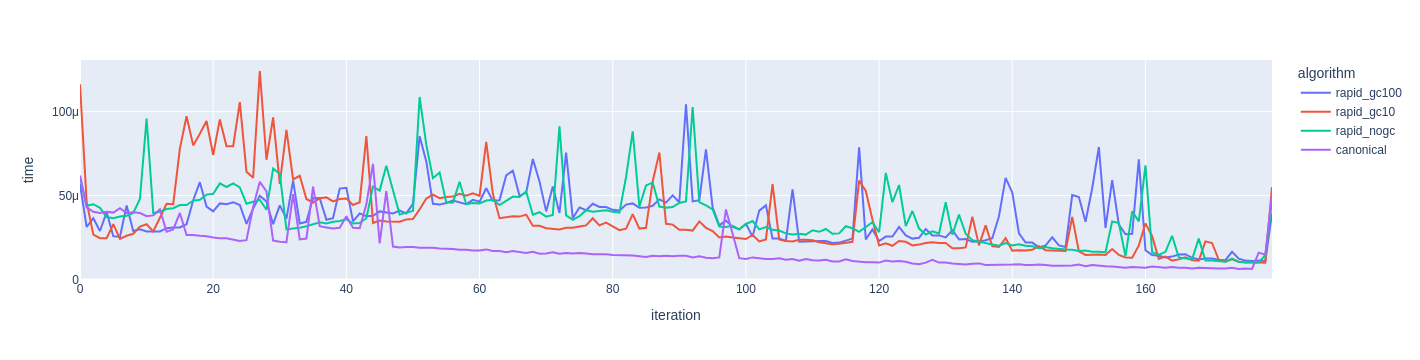

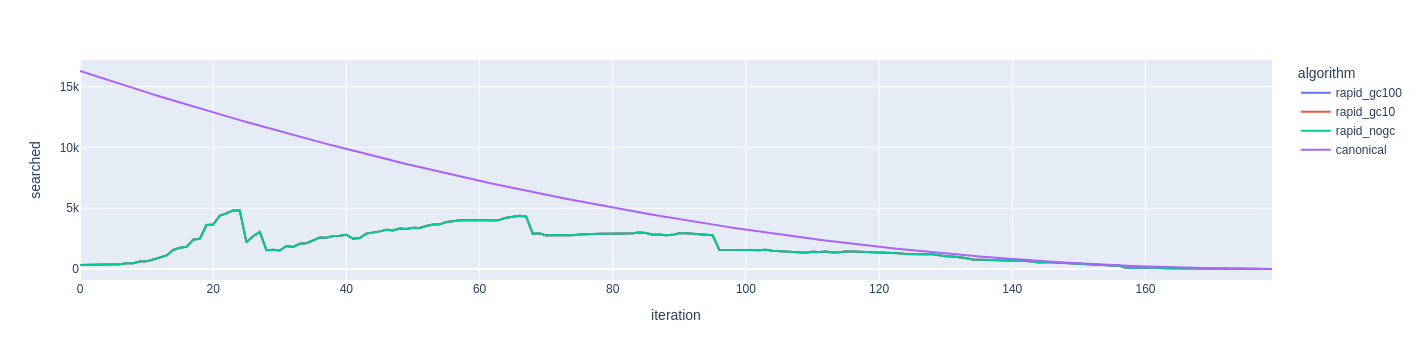

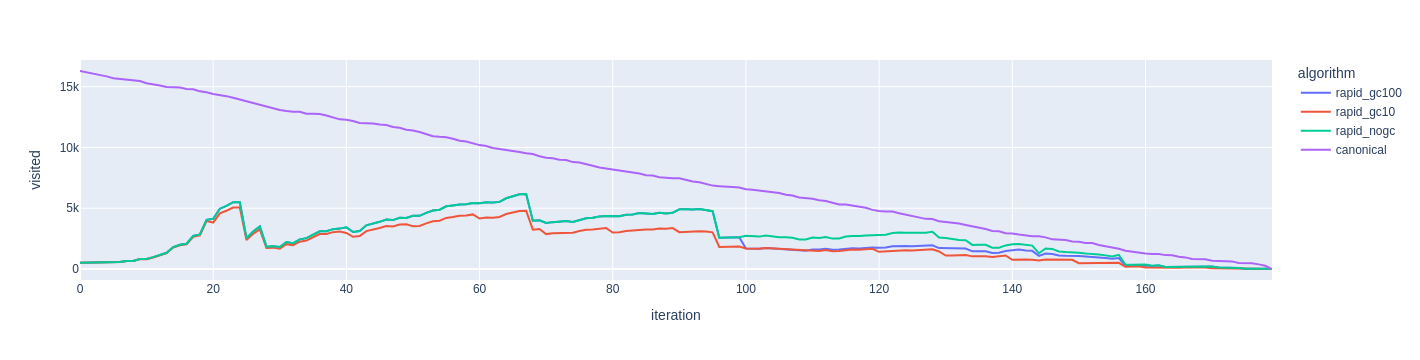

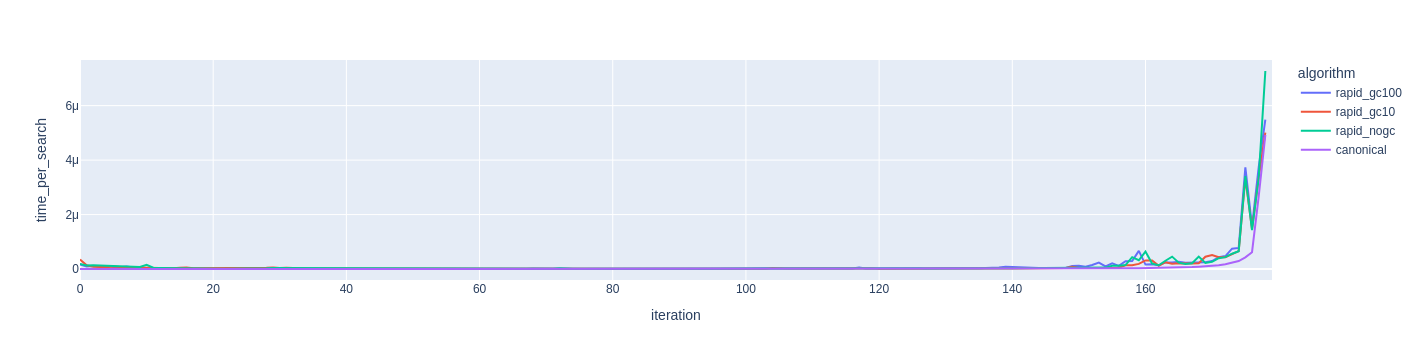

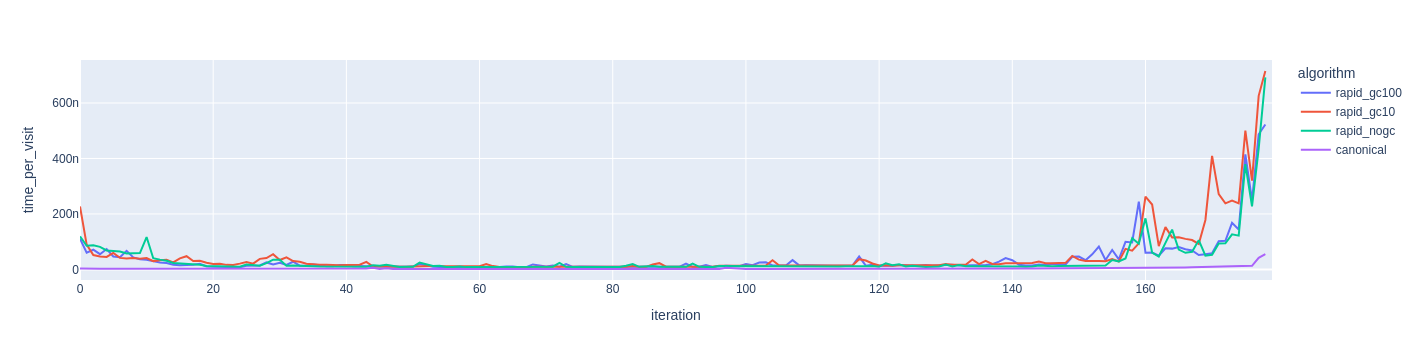

In [30]:
run_diagnostics(small_D)

## Medium

In [31]:
medium = zarr.load("../data/medium/dist.zarr.zip")
medium_D = squareform(medium)
medium_D.shape

(472, 472)

In [32]:
medium_Z = anjl.canonical_nj(medium_D)

In [33]:
medium_Z_r = anjl.rapid_nj(medium_D)

In [34]:
%%timeit -r50 -n1
anjl.canonical_nj(medium_D)

36.4 ms ± 7.64 ms per loop (mean ± std. dev. of 50 runs, 1 loop each)


In [35]:
%%timeit -r30 -n1
anjl.rapid_nj(medium_D, gc=None)

60.4 ms ± 3.31 ms per loop (mean ± std. dev. of 30 runs, 1 loop each)


In [36]:
%%timeit -r30 -n1
anjl.rapid_nj(medium_D, gc=10)

43.3 ms ± 2.2 ms per loop (mean ± std. dev. of 30 runs, 1 loop each)


In [37]:
%%timeit -r30 -n1
anjl.rapid_nj(medium_D, gc=100)

47.8 ms ± 3.58 ms per loop (mean ± std. dev. of 30 runs, 1 loop each)


In [38]:
%%timeit -r20 -n1
anjl.rapid_nj(medium_D, gc=1)

89.4 ms ± 4.42 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)


canonical... 0.04s
rapid_gc100... 0.05s
rapid_gc10... 0.05s
rapid_nogc... 0.07s


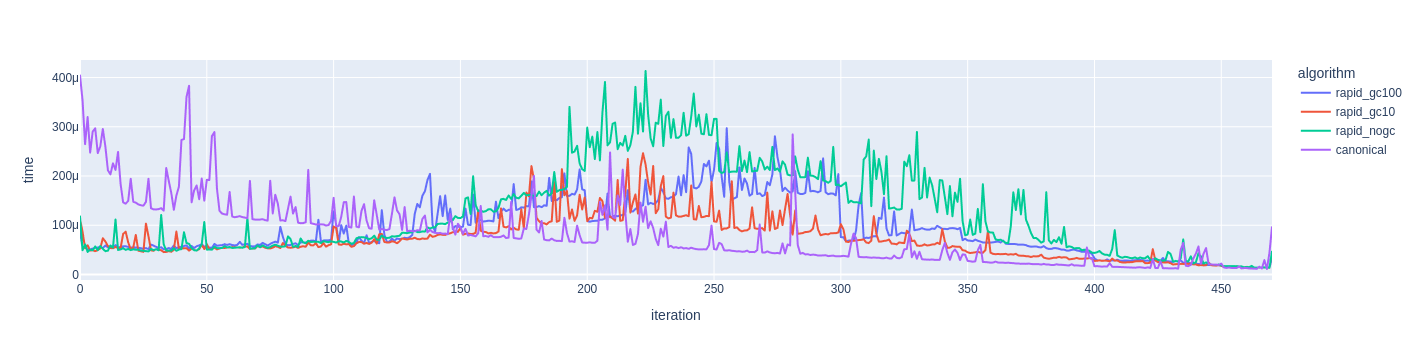

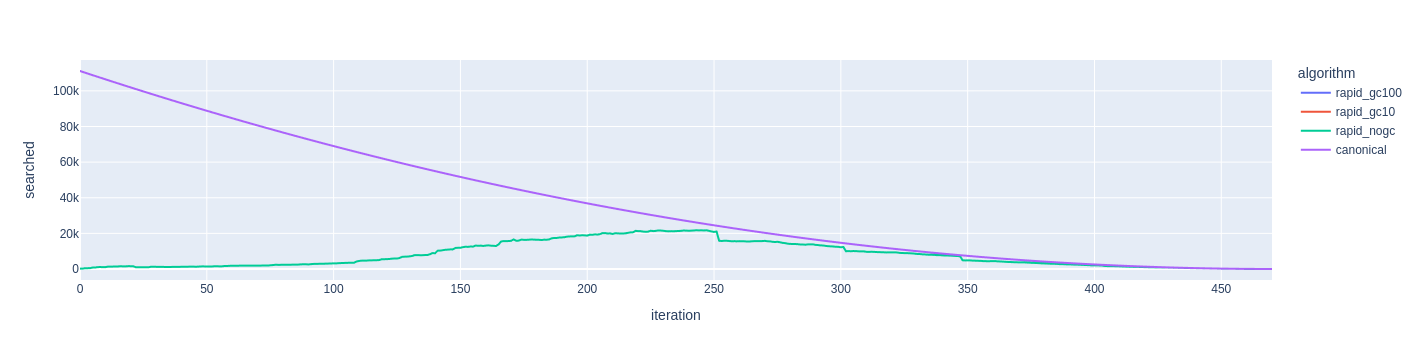

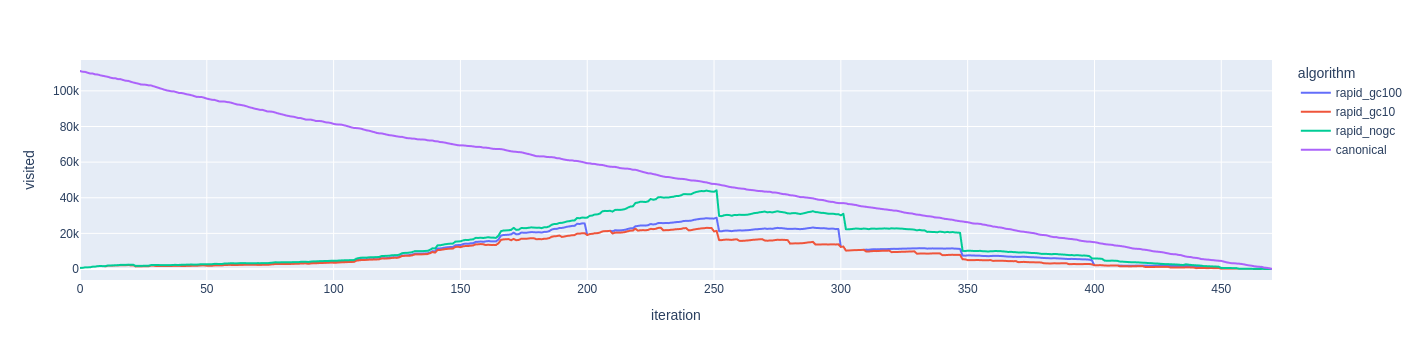

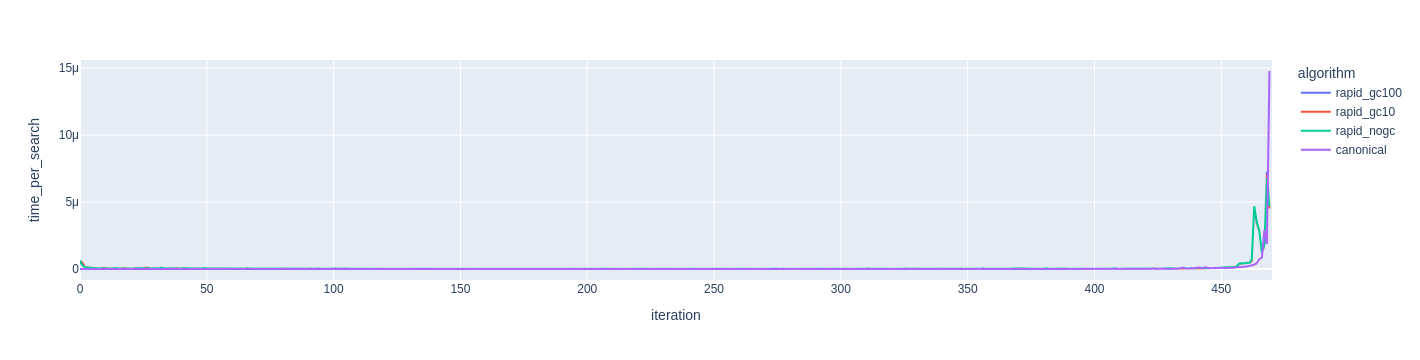

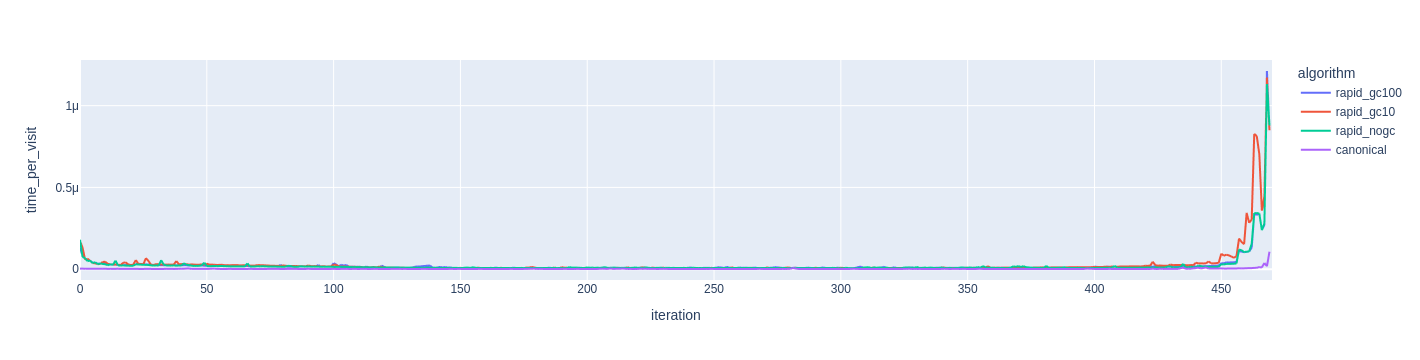

In [39]:
run_diagnostics(medium_D)

In [40]:
# %%profila
# anjl.canonical_nj(medium_D)

In [41]:
# %%profila
# anjl.rapid_nj(medium_D, gc=100)

## Large

In [42]:
large = zarr.load("../data/large/dist.zarr.zip")
large_D = squareform(large)
shuffle = np.random.choice(large_D.shape[0], size=2000, replace=False)
large_D_shuffled = large_D.take(shuffle, axis=0).take(shuffle, axis=1)
large_D_shuffled

array([[ 0., 22., 26., ..., 28., 28., 27.],
       [22.,  0., 22., ..., 18., 22., 15.],
       [26., 22.,  0., ..., 28., 22., 25.],
       ...,
       [28., 18., 28., ...,  0., 30., 17.],
       [28., 22., 22., ..., 30.,  0., 25.],
       [27., 15., 25., ..., 17., 25.,  0.]], dtype=float32)

canonical... 3.03s
rapid_gc100... 4.31s
rapid_gc10... 3.40s
rapid_nogc... 3.38s


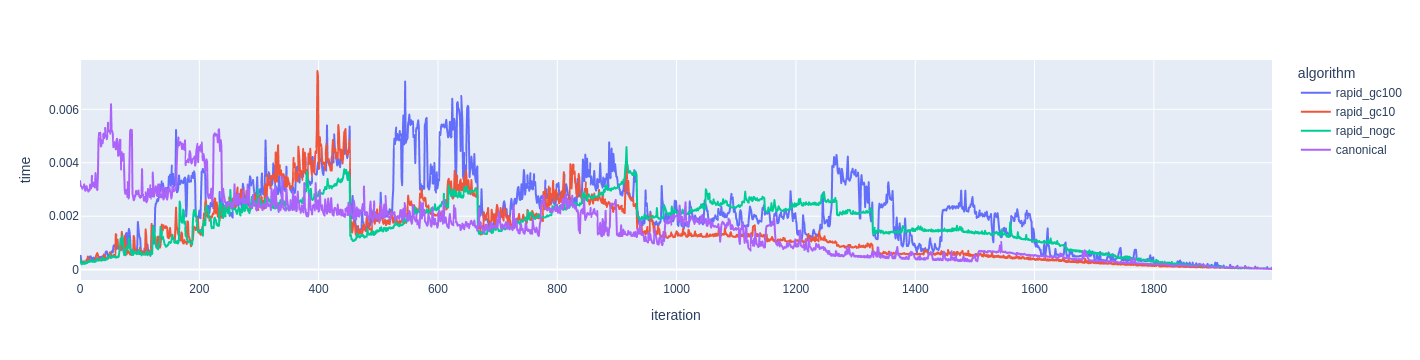

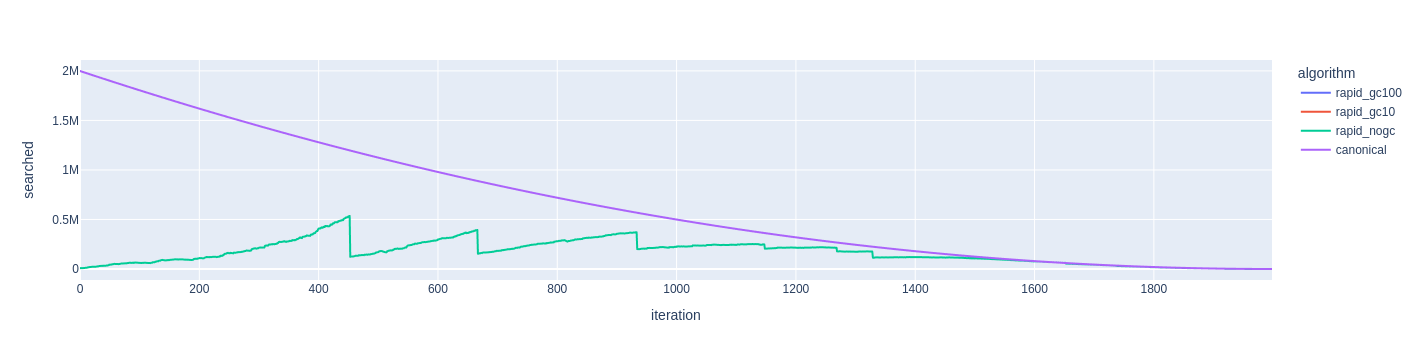

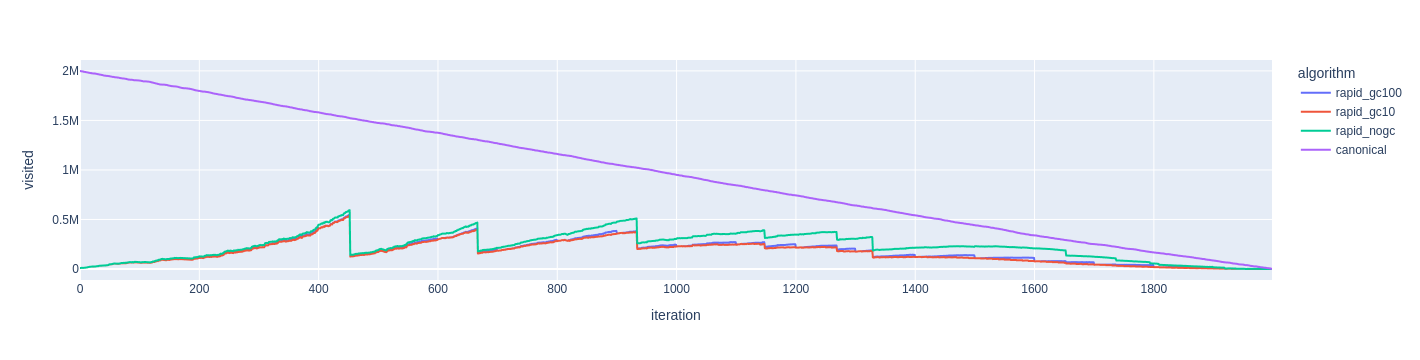

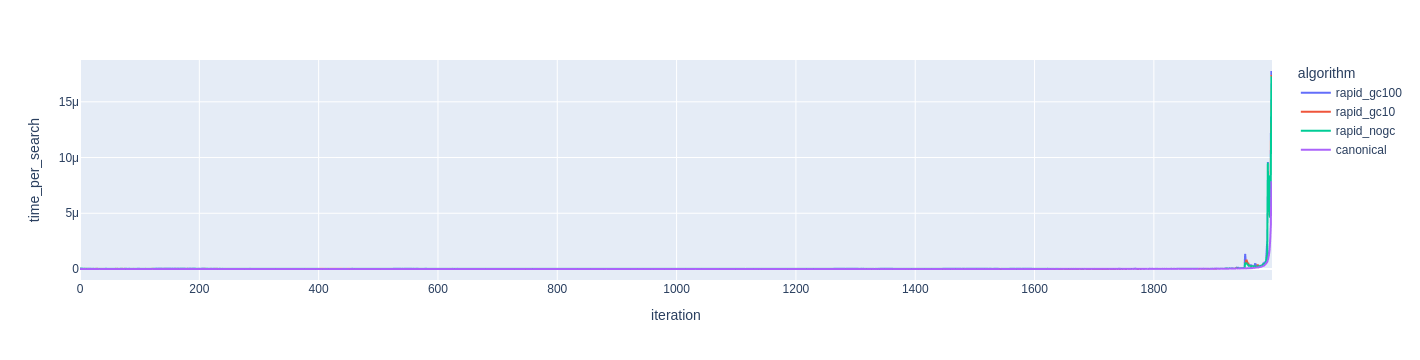

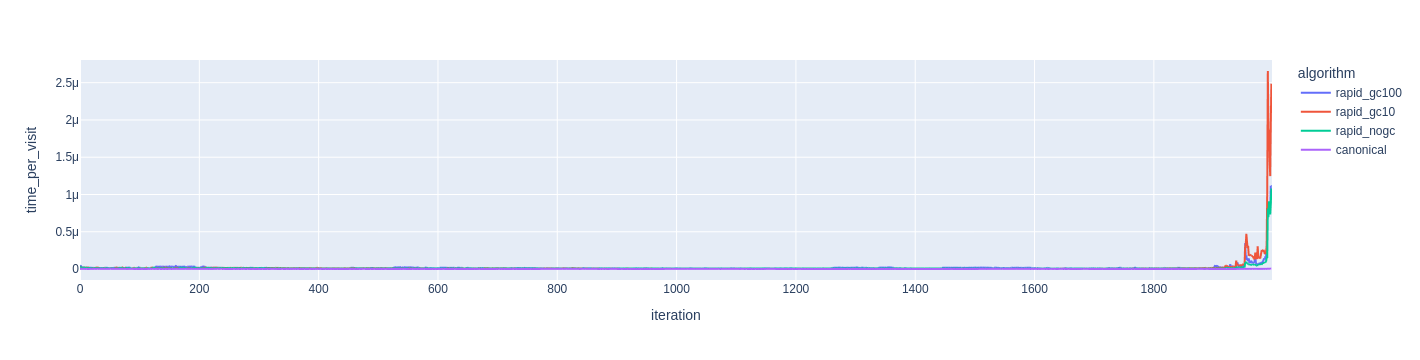

In [43]:
run_diagnostics(large_D_shuffled)

In [44]:
# %%profila
# large_Z = anjl.canonical_nj(large_D_shuffled)

# %%profila
# large_Z = anjl.rapid_nj(large_D_shuffled, gc=100)

In [45]:
%%timeit -r5 -n1
anjl.canonical_nj(large_D_shuffled)

2.5 s ± 297 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [ ]:
%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=10)

In [ ]:
%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=100)

In [ ]:
%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=200)

In [ ]:
%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=None)

In [ ]:
%%timeit -r3 -n1
np.argsort(large_D_shuffled, axis=1)

In [ ]:
%%timeit -r1000 -n1
np.argsort(large_D_shuffled[0])

## XL

In [ ]:
xxl = zarr.load("../data/xxl/dist.zarr.zip")
xxl_D = squareform(xxl)
xxl_D.shape

In [ ]:
xxl_shuffle = np.random.choice(xxl_D.shape[0], size=4000, replace=False)
xxl_D_shuffled = xxl_D.take(xxl_shuffle, axis=0).take(xxl_shuffle, axis=1)
xxl_D_shuffled

In [ ]:
# %%profila
# large_Z = anjl.canonical_nj(large_D_shuffled)

# %%profila
# large_Z = anjl.rapid_nj(large_D_shuffled, gc=100)

In [ ]:
run_diagnostics(xxl_D_shuffled)

## Sandbox

In [ ]:
import anjl._canonical
import anjl._rapid

In [ ]:
# anjl._canonical._canonical_nj_search.inspect_types()

In [ ]:
# anjl._rapid._rapid_search.inspect_types()